# Movielens 영화 추천 실습 🍿
<루브릭>  
1. CSR matrix가 정상적으로 만들어졌다.
- 사용자와 아이템 개수를 바탕으로 정확한 사이즈로 만들었다.
2. MF 모델이 정상적으로 훈련되어 그럴듯한 추천이 이루어졌다.
- 사용자와 아이템 벡터 내적수치가 의미있게 형성되었다.
3. 비슷한 영화 찾기와 유저에게 추천하기의 과정이 정상적으로 진행되었다.
- MF모델이 예측한 유저 선호도 및 아이템간 유사도, 기여도를 측정하고 의미를 분석해보았다.

# 1) 데이터 준비와 전처리  
- Movielens 데이터는 rating.dat 안에 이미 인덱싱까지 완료된 사용자-영화-평점 데이터가 깔끔하게 정리되어 있습니다.

In [1]:
import pandas as pd
import os
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
import os
import numpy as np


#데이터 준비
rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [3]:
#데이터 전처리
ratings = ratings[ratings['ratings']>=3] #ratings 3 미만 데이터 제거
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [4]:
# ratings 컬럼의 이름을 counts로 바꿉니다.
ratings.rename(columns={'ratings':'counts'}, inplace=True)

In [5]:
ratings['counts']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: counts, Length: 836478, dtype: int64

In [7]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


# MF모델 구성하기

# 2)데이터 분석
- ratings에 있는 유니크한 영화 개수
- ratings에 있는 유니크한 사용자 수
- 가장 인기 있는 영화 30개(인기순)

In [8]:
# 영화를 title로 입력할 것이기때문에 title이란 컬럼을 불러와야합니다.
ratings = pd.merge(ratings, movies[['title', 'movie_id']], on='movie_id', how='left')
ratings

,user_id,movie_id,counts,timestamp,title
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975)
1,1,661,3,978302109,James and the Giant Peach (1996)
2,1,914,3,978301968,My Fair Lady (1964)
3,1,3408,4,978300275,Erin Brockovich (2000)
4,1,2355,5,978824291,"Bug's Life, A (1998)"
...,...,...,...,...,...
836473,6040,1090,3,956715518,Platoon (1986)
836474,6040,1094,5,956704887,"Crying Game, The (1992)"
836475,6040,562,5,956704746,Welcome to the Dollhouse (1995)
836476,6040,1096,4,956715648,Sophie's Choice (1982)


In [9]:
ratings['movie_id'].nunique() #ratings에 있는 유니크한 영화 개수

3628

In [10]:
ratings['user_id'].nunique() #ratings에 있는 유니크한 사용자 수

6039

In [17]:
# 평점 3,4,5 모두 인기있는 경우라고 정한다.
# 3,4,5점을 한번 받으면 1 count로 정하고, 각 영화에 대한 총 count수를 로 정렬한다. 

movies_count = ratings.groupby('title')['counts'].count()
movies_count.sort_values(ascending=False).head(30)


title
American Beauty (1999)                                   3211
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
Terminator 2: Judgment Day (1991)                        2509
Silence of the Lambs, The (1991)                         2498
Raiders of the Lost Ark (1981)                           2473
Back to the Future (1985)                                2460
Matrix, The (1999)                                       2434
Jurassic Park (1993)                                     2413
Sixth Sense, The (1999)                                  2385
Fargo (1996)                                             2371
Braveheart (1995)                                        2314
Men in Black (1997)                                      2297
Schindler's List (1993)                                  2257
Pr

# 3) 내가 선호하는 영화를 5가지 골라서 ratings에 추가


In [10]:
movie_df[movie_df['title'].str.lower().str.contains('aladdin')].head(1)

,movie_id,title,genre,user_id,counts,timestamp
130190,588,Aladdin (1992),Animation|Children's|Comedy|Musical,1,4,978824268


In [18]:
# 내가 선호하는 영화를 5가지 골라서 rating에 추가
my_favorite = ['mission impossible (1996)','gravity (2013)', 'minions (2015)', "killer's bodyguard (2017)",  'aladdin (2019)']

my_list = pd.DataFrame({'user_id': ['elly']*5, 'title': my_favorite, 'counts':[5]*5})

if not ratings.isin({'user_id':['elly']})['user_id'].any(): 
    ratings = ratings.append(my_list)                         

ratings.tail(10)     

,user_id,movie_id,counts,timestamp,title
836473,6040,1090.0,3,956715518.0,Platoon (1986)
836474,6040,1094.0,5,956704887.0,"Crying Game, The (1992)"
836475,6040,562.0,5,956704746.0,Welcome to the Dollhouse (1995)
836476,6040,1096.0,4,956715648.0,Sophie's Choice (1982)
836477,6040,1097.0,4,956715569.0,E.T. the Extra-Terrestrial (1982)
0,elly,NaN,5,NaN,mission impossible (1996)
1,elly,NaN,5,NaN,gravity (2013)
2,elly,NaN,5,NaN,minions (2015)
3,elly,NaN,5,NaN,killer's bodyguard (2017)
4,elly,NaN,5,NaN,aladdin (2019)


In [19]:
# 사용하는 컬럼만 남겨줍니다.
ratings = ratings[['user_id','title', 'counts']]
ratings.sort_index()

,user_id,title,counts
0,1,One Flew Over the Cuckoo's Nest (1975),5
0,elly,mission impossible (1996),5
1,1,James and the Giant Peach (1996),3
1,elly,gravity (2013),5
2,1,My Fair Lady (1964),3
...,...,...,...
836473,6040,Platoon (1986),3
836474,6040,"Crying Game, The (1992)",5
836475,6040,Welcome to the Dollhouse (1995),5
836476,6040,Sophie's Choice (1982),4


In [21]:
# 고유한 유저, 아티스트를 찾아내는 코드
user_unique = ratings['user_id'].unique()
movie_unique = ratings['title'].unique()

# 유저, 아티스트 indexing 하는 코드 
user_to_idx = {v:k for k,v in enumerate(user_unique)}
movie_to_idx = {v:k for k,v in enumerate(movie_unique)}

In [25]:
# 인덱싱이 잘 되었는지 확인해 봅니다. 
print(user_to_idx['elly'])  
print(movie_to_idx['mission impossible (1996)'])

6039
3628


In [27]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = ratings['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(ratings):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    ratings['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# artist_to_idx을 통해 artist 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_movie_data = ratings['title'].map(movie_to_idx.get).dropna()
if len(temp_movie_data) == len(ratings):
    print('title column indexing OK!!')
    ratings['title'] = temp_movie_data
else:
    print('title column indexing Fail!!')

ratings

user_id column indexing Fail!!
title column indexing Fail!!


,user_id,title,counts
0,0,0,5
1,0,1,3
2,0,2,3
3,0,3,4
4,0,4,5
...,...,...,...
0,6039,3628,5
1,6039,3629,5
2,6039,3630,5
3,6039,3631,5


# 4) CSR matrix를 직접 만들기

In [28]:
num_user = ratings['user_id'].nunique()
num_movie = ratings['title'].nunique()

csr_data = csr_matrix((ratings.counts, (ratings.user_id, ratings.title)), shape=(num_user, num_movie)) 
csr_data

<6040x3633 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Row format>

# 5) als_model = AlternatingLeastSquares 모델 훈련

In [29]:
# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [223]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=500, regularization=0.01, use_gpu=False, iterations=50, dtype=np.float32)

In [224]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3633x6040 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [225]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/50 [00:00<?, ?it/s]

# 6) 내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악하기

In [226]:
elly, mission = user_to_idx['elly'], movie_to_idx['mission impossible (1996)']
elly_vector, mission_vector = als_model.user_factors[elly], als_model.item_factors[mission]

In [227]:
elly_vector

array([ 1.85690876e-02,  2.47570351e-02,  2.78976820e-02,  2.09974665e-02,
       -6.70303404e-02, -9.05083027e-03,  3.45077389e-03, -6.75135553e-02,
        1.75155289e-02, -2.94442959e-02, -4.73467186e-02,  9.48990360e-02,
        7.84568395e-03,  3.11580691e-02, -4.10277909e-03,  3.09960935e-02,
        6.51415728e-04,  4.81710583e-02, -8.33619386e-02, -4.83287219e-03,
        8.00476521e-02,  9.18691698e-03, -4.43710238e-02,  4.10018303e-02,
       -7.60913193e-02, -3.76483575e-02,  1.85056664e-02,  7.01362267e-02,
        4.24734224e-03,  6.74940944e-02, -5.58294766e-02,  1.81152672e-02,
        8.99731833e-03,  5.85527867e-02,  3.31963645e-03,  3.03172832e-03,
       -2.69628968e-02,  4.17342111e-02, -7.86562636e-02, -3.80027704e-02,
       -3.43324021e-02, -7.49853030e-02, -3.65429707e-02,  2.61955168e-02,
        1.54528266e-03,  7.13400692e-02, -5.52997962e-02,  6.52043596e-02,
       -3.44413742e-02, -7.13243261e-02, -1.20205209e-02, -1.29510248e-02,
        1.72626099e-03, -

In [228]:
mission_vector

array([ 0.00507116,  0.00383215,  0.00508935,  0.00488617,  0.00142747,
        0.00416236,  0.00447025,  0.00240746,  0.00430672,  0.00431297,
        0.00308437,  0.00751319,  0.00282157,  0.00743008,  0.00462427,
        0.0050638 ,  0.00557096,  0.00633468,  0.00317444,  0.00433574,
        0.0080576 ,  0.00458713,  0.00294045,  0.00659442,  0.00248038,
        0.00249295,  0.00552119,  0.00644921,  0.00486292,  0.00740795,
        0.00263269,  0.00400866,  0.00438521,  0.00711048,  0.00291323,
        0.00476701,  0.00352032,  0.00625111,  0.00250046,  0.00352105,
        0.004365  ,  0.00228614,  0.00379535,  0.00456942,  0.00390975,
        0.00652696,  0.00269082,  0.00628056,  0.00414651,  0.00361113,
        0.00420501,  0.00412971,  0.00577933,  0.00200635,  0.00398962,
        0.00613134,  0.00259311,  0.00476564,  0.00490727,  0.00537335,
        0.00403694,  0.00427346,  0.00225342,  0.00095242,  0.00332926,
        0.00755853,  0.00458466,  0.00421232,  0.00554803,  0.00

In [229]:
# elly과 mission를 내적하는 코드
np.dot(elly_vector, mission_vector)

0.027903413

In [230]:
#killer's bodyguard (2017) vector을 가지고 선호도 예측 확인
killer = movie_to_idx["killer's bodyguard (2017)"]
killer_vector = als_model.item_factors[killer]

print(np.dot(elly_vector, killer_vector))

0.027136741


# 7) 내가 좋아하는 영화와 비슷한 영화를 추천받기


In [231]:
idx_to_movie = {v:k for k,v in movie_to_idx.items()}

def get_similar_movie(movie_name: str):
    movie_id = movie_to_idx[movie_name]
    similar_movie = als_model.similar_items(movie_id)
    similar_movie = [idx_to_movie[i[0]] for i in similar_movie]
    return similar_movie

In [232]:
get_similar_movie('mission impossible (1996)') 

['gravity (2013)',
 'minions (2015)',
 "killer's bodyguard (2017)",
 'aladdin (2019)',
 'mission impossible (1996)',
 'Chain of Fools (2000)',
 'Aiqing wansui (1994)',
 'For Ever Mozart (1996)',
 'Make Them Die Slowly (Cannibal Ferox) (1980)',
 'Loser (1991)']

# 8) 내가 가장 좋아할 만한 영화들을 추천받기

In [233]:
user = user_to_idx['elly']
# recommend에서는 user*item CSR Matrix를 받습니다.
movie_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
movie_recommended

[(570, 0.03550586),
 (726, 0.030988542),
 (1135, 0.030901095),
 (1959, 0.030522574),
 (3332, 0.03009453),
 (682, 0.029916544),
 (3540, 0.029154763),
 (2134, 0.028687388),
 (2313, 0.028675068),
 (3059, 0.028671643),
 (3168, 0.028252458),
 (3265, 0.02803256),
 (2694, 0.027939314),
 (3479, 0.027771872),
 (3322, 0.0276749),
 (3616, 0.027639894),
 (3305, 0.027617365),
 (3518, 0.02735417),
 (3037, 0.027331494),
 (3615, 0.02729825)]

In [234]:
[idx_to_movie[i[0]] for i in movie_recommended]

['Rocketeer, The (1991)',
 'Blair Witch Project, The (1999)',
 'For All Mankind (1989)',
 'Agnes Browne (1999)',
 'Jail Bait (1954)',
 'So I Married an Axe Murderer (1993)',
 'Prince Valiant (1997)',
 'Universal Soldier: The Return (1999)',
 '20 Dates (1998)',
 'Henry: Portrait of a Serial Killer, Part 2 (1996)',
 'Trial by Jury (1994)',
 'Quiet Room, The (1996)',
 'Diamonds (1999)',
 'Yankee Zulu (1994)',
 'Two Much (1996)',
 'Song of Freedom (1936)',
 "Those Who Love Me Can Take the Train (Ceux qui m'aiment prendront le train) (1998)",
 'Napoleon and Samantha (1972)',
 'Across the Sea of Time (1995)',
 'Chain of Fools (2000)']

# 회고  
### 1) 과정 
1) 데이터 준비와 전처리  
2) 데이터 분석  
- ratings에 있는 유니크한 영화 개수  
- ratings에 있는 유니크한 사용자 수  
- 가장 인기 있는 영화 30개(인기순)  

3) 내가 선호하는 영화를 5가지 골라서 ratings에 추가해주기  
4) CSR matrix를 직접 만들어 보기  
5) als_model = AlternatingLeastSquares 모델을 직접 구성하여 훈련시키기  
6) 내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악하기  
7) 내가 좋아하는 영화와 비슷한 영화를 추천받기  
8) 내가 가장 좋아할 만한 영화들을 추천받기 

#### 벡터내적값 1에 가깝게 만드는 과정

# 선호도 예측(최적화시키기)
### Implicit AlternatingLeastSquares 모델의 선언 할때
**->핵심: 벡터내적 값이 1에 가까워질수록 내가 좋아하는 영화와 유사하다는 것이다. 1을 넘어버리면 overfitting되니 조심!**

**(1) factors=10, regularization=0.01, interations = 100**
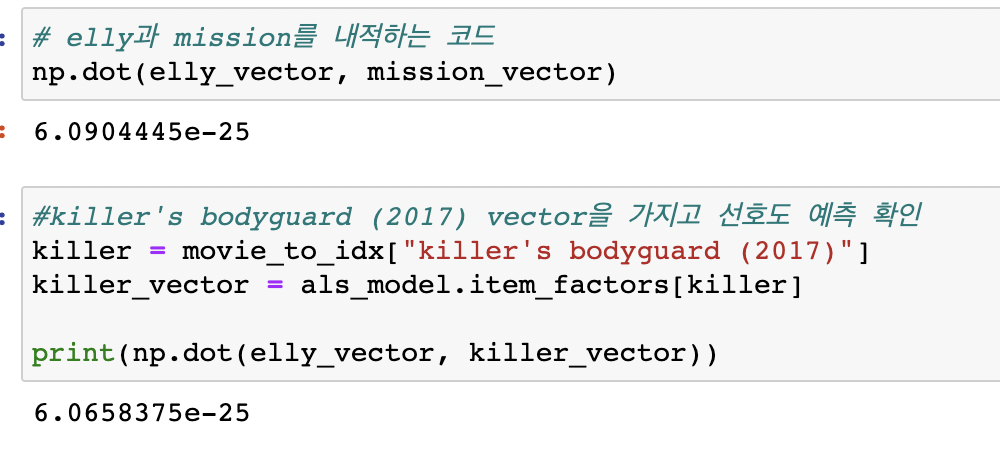

**(2) factors=50, regularization=0.01, interations = 100**
- 2.4xxxx-24

**(3) factors=100, regularization=0.01, interations = 100**
- 1.4xxxxe-23

=>값이 너무 낮게 나온것을 확인할 수 있다. 그래도 factors를 높이니 조금씩 학습되어진다.

**(3)factors=100, regularization=0.01, iterations=15**
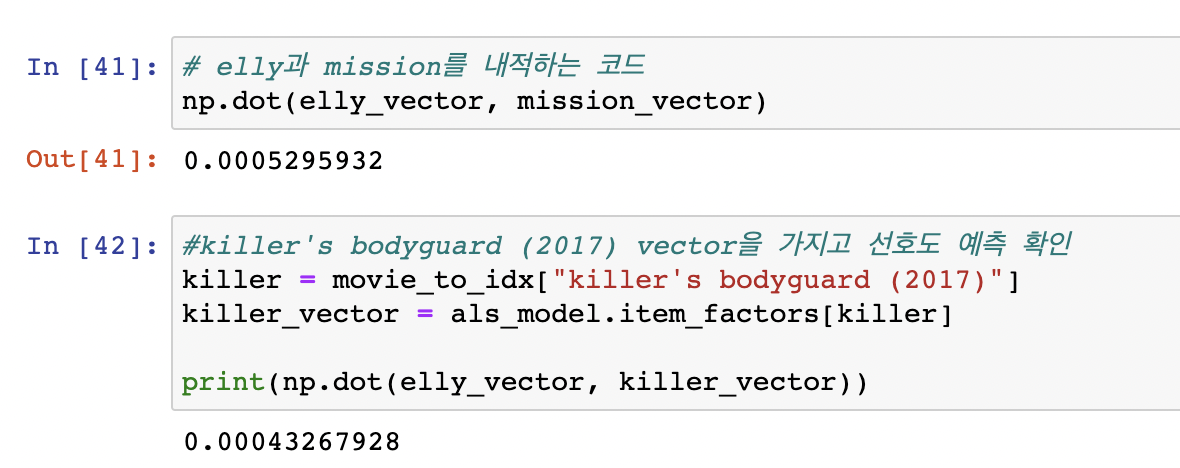

**(4)factors=100, regularization=0.01, iterations=1**
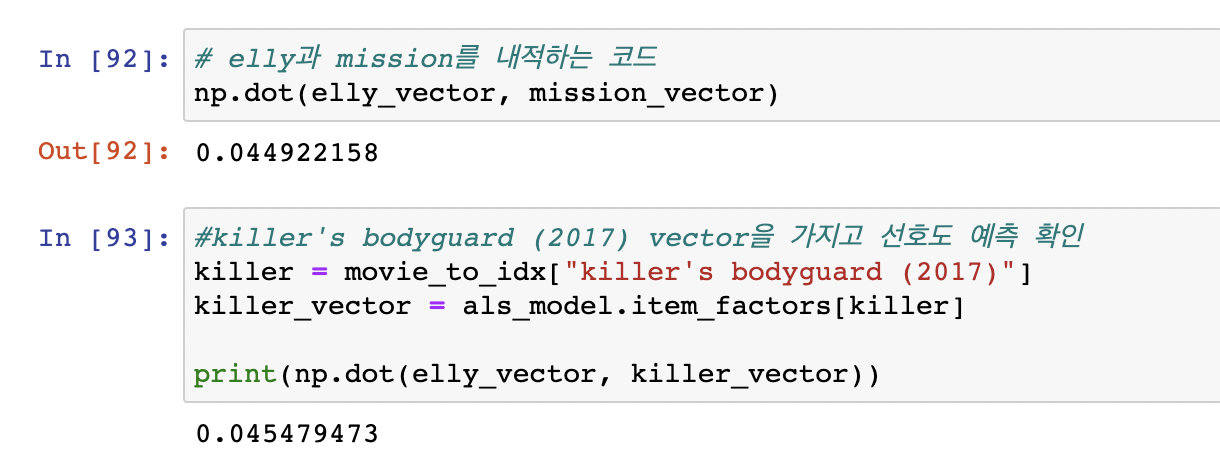

**(6)factors=150, regularization=0.01, iterations=1**
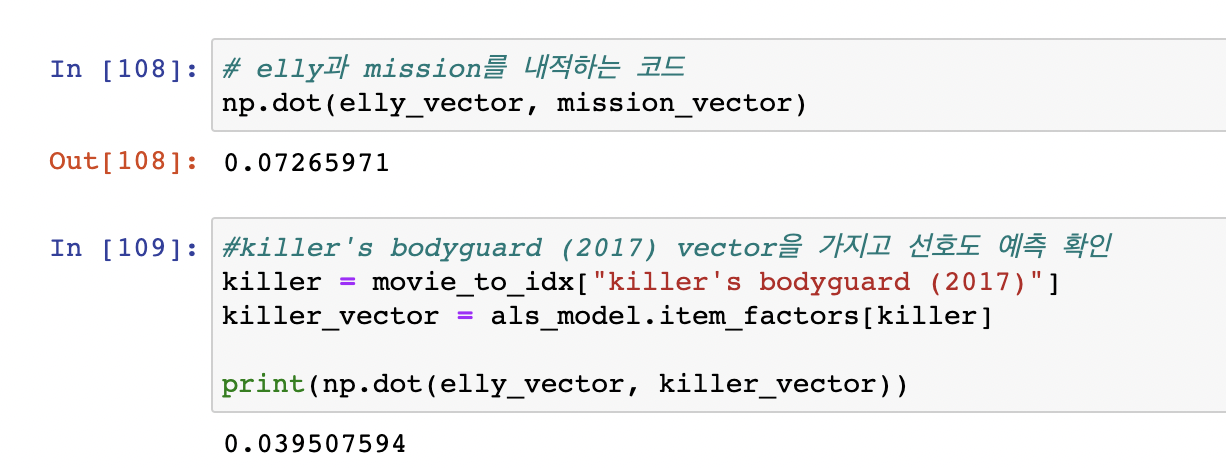

-> iteration은 epoch와 같은 역할을 하는거 같은데 더 작아질수록 벡터내적값이 올라가서 혼란스럽다

**=> 작성한 코드들을 잘 확인해 보니 ratings 데이터에 counts컬럼이 있는데 count컬럼이 하나 더 생성되어있었다. 데이터가 제대로 작성되어있지 않아 내적값을 계산하는데 혼동을 준 것이다.
=> 위의 수치는 제대로된 계산으로 나온 결과값이 아니기때문에 올바르지 않다.**


### 2)결과
- factors=500, regularization=0.01, iterations=50 이 가장 좋은 결과를 보였다
- 이 수치는 신뢰도를 이야기하는데 2.7%정도의 신뢰도가 나왔다. 어떤 값이 가장 좋은 하이퍼파라미터인지 더 알아볼 필요가 있을 듯하다.
- 그래서 좋아할만한 영화 추천이에서 내가 봤던 영화라던지 흥미를 끄는건 몇가지 정도 밖에 되지않았다.
- 이렇게 추천 시스템을 해보니 다른것 보다는 흥미를 가기고 했다.

### 3) Reference
- https://velog.io/@yeeun/Matrix-Factorization-%EA%B8%B0%EB%B0%98-%EC%B6%94%EC%B2%9C
- https://meissa.tistory.com/32